## Trial Recurrent Neural Network

With the change to the data set (i.e. dropping betting data), it seems that we have to go back to basics, because earlier experiments are no longer valid, resulting in a different set of algorithms having stronger performance. The experiments with deep learning in 2019 yielded performance comparable to simpler models, and I decided not to pursue them at the time, because comparable performance isn't worth the extra time for training/param-tuning required. With the current benchmark being a bit lower, however, it's worth seeing if a deep neural net can surpass simpler models.

To avoid spending too much time on this, I'm going to focus on RNNs, because it was the best-performing architecture from earlier experiments and lends itself to the time-based nature of AFL matches.

## Code setup

In [1]:
%load_ext autoreload

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.experimental import enable_halving_search_cv
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import get_scorer
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from mlxtend.feature_selection import ColumnSelector

from augury.ml_data import MLData
from augury.model_tracking import graph_tf_model_history
from augury.settings import SEED, CV_YEAR_RANGE, CATEGORY_COLS, TEAM_NAMES, ROUND_TYPES, VENUES
from augury.sklearn.metrics import match_accuracy_scorer
from augury.sklearn.models import RNNRegressor
from augury.sklearn.model_selection import year_cv_split
from augury.sklearn.preprocessing import ColumnDropper

np.random.seed(SEED)

In [3]:
data = MLData(train_year_range=(max(CV_YEAR_RANGE),))
data.data

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-02-25 07:20:32,964 - kedro.io.data_catalog - INFO - Loading data from `full_data` (JSONDataSet)...


team      oppo_team round_type  \
Adelaide         1991 1           Adelaide       Hawthorn    Regular   
                      2           Adelaide        Carlton    Regular   
                      3           Adelaide         Sydney    Regular   
                      4           Adelaide       Essendon    Regular   
                      5           Adelaide     West Coast    Regular   
...                                    ...            ...        ...   
Western Bulldogs 2021 19  Western Bulldogs       Adelaide    Regular   
                      20  Western Bulldogs      Melbourne    Regular   
                      21  Western Bulldogs       Essendon    Regular   
                      22  Western Bulldogs       Hawthorn    Regular   
                      23  Western Bulldogs  Port Adelaide    Regular   

                                   venue prev_match_oppo_team  \
Adelaide         1991 1    Football Park                    0   
                      2    Football Park             Hawthorn   
                      3           S.C.G.              Carlton   
                      4       Windy Hill               Sydney   
                      5          Subiaco             Essendon   
...                                  ...                  ...   
Western Bulldogs 2021 19  Eureka Stadium           Gold Coast   
                      20          M.C.G.             Adelaide   
                      21       Docklands            Melbourne   
                      22       York Park             Essendon   
                      23       Docklands             Hawthorn   

                         oppo_prev_match_oppo_team                      date  \
Adelaide         1991 1                  Melbourne 1991-03-22 03:56:00+00:00   
                      2                    Fitzroy 1991-03-31 03:56:00+00:00   
                      3                   Hawthorn 1991-04-07 03:05:00+00:00   
                      4            North Melbourne 1991-04-13 03:30:00+00:00   
                      5            North Melbourne 1991-04-21 05:27:00+00:00   
...                                            ...                       ...   
Western Bulldogs 2021 19                West Coast 2021-07-24 02:20:00+00:00   
                      20                Gold Coast 2021-07-31 02:20:00+00:00   
                      21                    Sydney 2021-08-07 02:20:00+00:00   
                      22               Collingwood 2021-08-14 02:11:00+00:00   
                      23                   Carlton 2021-08-21 02:20:00+00:00   

                          team_goals  team_behinds  score  ...  \
Adelaide         1991 1           24            11    155  ...   
                      2           12             9     81  ...   
                      3           19            18    132  ...   
                      4            6            11     47  ...   
                      5            9            11     65  ...   
...                              ...           ...    ...  ...   
Western Bulldogs 2021 19           0             0      0  ...   
                      20           0             0      0  ...   
                      21           0             0      0  ...   
                      22           0             0      0  ...   
                      23           0             0      0  ...   

                          oppo_rolling_prev_match_time_on_ground_skew  \
Adelaide         1991 1                                           0.0   
                      2                                           0.0   
                      3                                           0.0   
                      4                                           0.0   
                      5                                           0.0   
...                                                               ...   
Western Bulldogs 2021 19                                          0.0   
                      20                              

### Create pipelines

## Runn RNN

### Basic RNN for baseline performance

RNNRegressor mostly uses the defaults for a Keras RNN model with LSTM cells. It has one hidden layer and measures accuracy, but optimises toward MAE, because accuracy doesn't lend itself easily to a loss function for a regressor. I chose 6 steps for the time-series, because that's a quarter of an average season, which seems like a decent starting point.

In [4]:
ELO_MODEL_COLS = [
    "prev_match_oppo_team",
    "oppo_prev_match_oppo_team",
    "prev_match_at_home",
    "oppo_prev_match_at_home",
    "date",
]

N_STEPS = 6

X_train, _ = data.train_data
n_features = X_train.shape[1] - len(ELO_MODEL_COLS)

rnn_pipeline = make_pipeline(
    ColumnDropper(cols_to_drop=ELO_MODEL_COLS),
    ColumnTransformer(
        [
            (
                "ordinalencoder",
                OrdinalEncoder(categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES, VENUES]),
                CATEGORY_COLS,
            )
        ],
        remainder=StandardScaler(),
    ),
    RNNRegressor(
        n_features=n_features,
        n_steps=N_STEPS,
        verbose=1,
        epochs=50,
    ),
)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
rnn_pipeline.fit(*data.train_data)
None

Epoch 1/50
770/770 [==============================] - 15s 13ms/step - loss: 30.4317 - regressor_team_match_accuracy: 0.6598 - val_loss: 29.1593 - val_regressor_team_match_accuracy: 0.6896
Epoch 2/50
770/770 [==============================] - 8s 11ms/step - loss: 28.5193 - regressor_team_match_accuracy: 0.6948 - val_loss: 28.6980 - val_regressor_team_match_accuracy: 0.6930
Epoch 3/50
770/770 [==============================] - 8s 10ms/step - loss: 27.9400 - regressor_team_match_accuracy: 0.7051 - val_loss: 28.4956 - val_regressor_team_match_accuracy: 0.6901
Epoch 4/50
770/770 [==============================] - 10s 12ms/step - loss: 27.6555 - regressor_team_match_accuracy: 0.7123 - val_loss: 28.2960 - val_regressor_team_match_accuracy: 0.6947
Epoch 5/50
770/770 [==============================] - 8s 10ms/step - loss: 27.5295 - regressor_team_match_accuracy: 0.7075 - val_loss: 27.9092 - val_regressor_team_match_accuracy: 0.6968
Epoch 6/50
770/770 [==============================] - 10s 13ms/

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


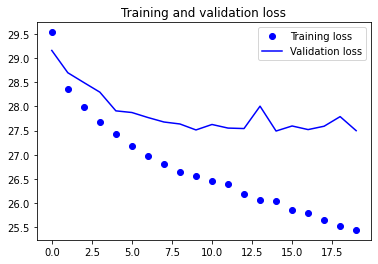

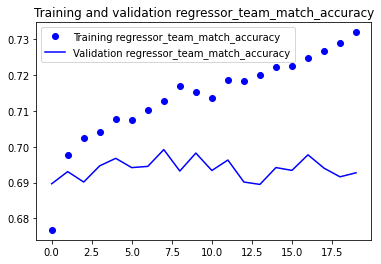

In [34]:
graph_tf_model_history(rnn_pipeline.steps[-1][1].history, metrics=['regressor_team_match_accuracy'])

Performance is in the ballpark with other top models, though about 2% lower accuracy (this is from being trained on a full training data set and validated on 2019 data, however, rather than using a multi-fold CV from recent years, so it's not apples-to-apples).

### SearchCV for a better model structure

Given all the potential parameters for an RNN, a little trial-and-error isn't going to give us a realistic indication of the model's performance, so we'll do a small parameter search to hopefully give us a better structure (i.e. # layers, # cells per layer) to start fine tuning.

In [8]:
[param for param in rnn_pipeline.get_params() if 'rnnregressor__' in param]

['rnnregressor__activity_regularizer',
 'rnnregressor__batch_size',
 'rnnregressor__bias_regularizer',
 'rnnregressor__dropout',
 'rnnregressor__epochs',
 'rnnregressor__kernel_regularizer',
 'rnnregressor__loss',
 'rnnregressor__metrics',
 'rnnregressor__n_categories',
 'rnnregressor__n_cells',
 'rnnregressor__n_features',
 'rnnregressor__n_hidden_layers',
 'rnnregressor__n_steps',
 'rnnregressor__n_teams',
 'rnnregressor__n_venues',
 'rnnregressor__optimizer',
 'rnnregressor__patience',
 'rnnregressor__recurrent_dropout',
 'rnnregressor__recurrent_regularizer',
 'rnnregressor__round_type_dim',
 'rnnregressor__team_dim',
 'rnnregressor__venue_dim',
 'rnnregressor__verbose']

In [7]:
PARAM_GRID = {
    'rnnregressor__dropout': stats.uniform(0.0, 0.5),
    'rnnregressor__n_cells': np.arange(20, 201),
    'rnnregressor__n_hidden_layers': np.arange(1, 11),
    'rnnregressor__n_steps': np.arange(2, 13), # ~10% to ~50% of a season
    'rnnregressor__recurrent_dropout': stats.uniform(0.0, 0.5),
}

rnn_pipeline.set_params(rnnregressor__verbose=0)

X_train, y_train = data.train_data

random_search = RandomizedSearchCV(
    rnn_pipeline,
    PARAM_GRID,
    scoring=match_accuracy_scorer,
    n_jobs=-1,
    cv=year_cv_split(X_train, CV_YEAR_RANGE),
    refit=False,
    verbose=2,
    error_score='raise',
    n_iter=5,
)

In [8]:
random_search.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=[(array([ True,  True,  True, ..., False, False, False]),
                        array([False, False, False, ..., False, False, False])),
                       (array([ True,  True,  True, ..., False, False, False]),
                        array([False, False, False, ..., False, False, False])),
                       (array([ True,  True,  True, ..., False, False, False]),
                        array([False, False, False, ..., False, False, False])),
                       (array([ True,  True,  True, ..., False, Fal...
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]),
                                        'rnnregressor__n_hidden_layers': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'rnnregressor__n_steps': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                                        'rnnregressor__recurrent_dropout': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f20a

In [9]:
random_search.cv_results_

{'mean_fit_time': array([ 502.99574385, 1143.82803593, 1099.88098235, 2476.79402208,
        1587.3754725 ]),
 'std_fit_time': array([110.2145125 , 296.66567002, 227.8016965 , 276.95753716,
        520.13637449]),
 'mean_score_time': array([ 2.43665953,  6.3504952 ,  5.72126551, 14.04012208,  3.95674524]),
 'std_score_time': array([0.28161701, 0.96080937, 1.96701075, 3.98480994, 2.23034507]),
 'param_rnnregressor__dropout': masked_array(data=[0.06974693032602092, 0.23338144662398996,
                    0.006632480579933264, 0.048836057003191935,
                    0.45466020103939103],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_rnnregressor__n_cells': masked_array(data=[34, 70, 108, 103, 183],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_rnnregressor__n_hidden_layers': masked_array(data=[3, 7, 2, 7, 2],
              mask=[False, False, False

In [12]:
results = (
    pd
    .DataFrame(random_search.cv_results_)
    .sort_values('rank_test_score')
    .filter(regex='mean_test_score|param_')
    .sort_index(axis=1)
)

results.head(20)

,mean_test_score,param_rnnregressor__dropout,param_rnnregressor__n_cells,param_rnnregressor__n_hidden_layers,param_rnnregressor__n_steps,param_rnnregressor__recurrent_dropout
1,0.658618,0.233381,70,7,6,0.22525
2,0.658595,0.006632,108,2,11,0.152307
4,0.655710,0.45466,183,2,9,0.377681
0,0.653778,0.069747,34,3,8,0.491615
3,0.646063,0.048836,103,7,9,0.017194


In [11]:
results.to_json('2.1-recurrent-neural-net-param-scores.json', indent=2, orient='records')

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Well, that was underwhelming. I got better performance in 2019 with some configurations that I arrived at via trial-and-error. I'll give the best of those a try to see if I just got a bad batch of params.

### Try RNN from 2019

This was more-or-less the configuration for the final RNN tested in `notebooks/2019_season/6.1-all-data-rnn.ipynb`, which got accuracies in the low 70s. The mix of validation seasons that we're using here are harder to predict, and thus produce lower accuracy across models, but we'll see if we can still get comparable performance.

In [18]:
existing_rnn_pipeline = make_pipeline(
    ColumnDropper(cols_to_drop=ELO_MODEL_COLS),
    ColumnTransformer(
        [
            (
                "ordinalencoder",
                OrdinalEncoder(categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES, VENUES]),
                CATEGORY_COLS,
            )
        ],
        remainder=StandardScaler(),
    ),
    RNNRegressor(
        n_features=n_features,
        verbose=1,
        epochs=50,
        n_hidden_layers=2,
        n_cells=100,
        n_steps=5,
        dropout=0.3,
        recurrent_dropout=0.6,
        patience=5,
    ),
)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
existing_rnn = cross_validate(
    rnn_pipeline,
    X_train,
    y_train,
    scoring=match_accuracy_scorer,
    n_jobs=None,
    cv=year_cv_split(X_train, CV_YEAR_RANGE),
    verbose=2,
    error_score='raise',
)
existing_rnn

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time= 2.3min
[CV] END .................................................... total time= 1.7min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.8min finished


{'fit_time': array([132.09458828,  98.06135702, 112.78712034, 135.38352323,
        102.62480307]),
 'score_time': array([0.6268425 , 0.58578753, 0.46472669, 0.55794644, 0.51531267]),
 'test_score': array([0.68932039, 0.6763285 , 0.67149758, 0.69082126, 0.65700483])}

In [22]:
existing_rnn['test_score'].mean()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6769945124525115

We have slightly better accuracy than from the best params from the CV, but it's still quite a bit worse than simple `Ridge`. I'm running low on time and patience, so I'm just going to go linear this season and look into deep learning model best practices to maybe come up with something useful for next season.